# Financial / Legal Text Classification

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
import torch
import torch.nn as nn
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, BertForSequenceClassification, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Loading data

In [2]:
df = pd.read_csv("/kaggle/input/5-document-clustering/legal_financial.csv")
df.rename(columns={'Label':'label'}, inplace=True)
df.head(10)

,Text,label
0,Citi Global Wealth Investments FX Snapshot Ma...,0
1,NOT GOVERNMENT INSURED.,1
2,NO BANK GUARANTEE.,1
3,"MAY LOSE VALUE February 20, 2023",1
4,"Source: Bloomberg L.P. (K = Thousand, M = Mil...",0
5,Sentiment Feb -- 66.4 66.4,0
6,Important Disclosure Citi analysts refers to ...,1
7,Citibank N.A.,1
8,and its affiliates / subsidiaries provide no i...,1
9,Investment products are not available to US pe...,1


In [3]:
df.describe()

,label
count,6507.000000
mean,0.409252
std,0.491734
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Text(0, 0.5, 'Number of Sentences')

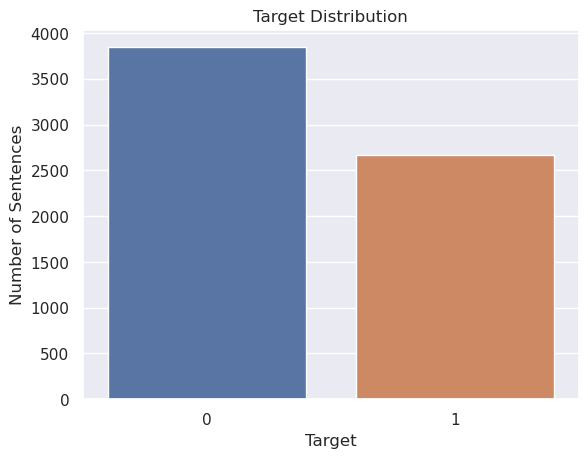

In [4]:
plt.figure()
sns.set(style='darkgrid')
sns.countplot(x='label', data = df)
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Number of Sentences')

In [5]:
def random_sentences(total_number, df):
    
    # Get the random number of reviews
    n_sentences = df.sample(total_number)
    
    # Print each one of the reviews
    for val in list(n_sentences.index):
        print("Sentence #{}".format(val))
        print(" - Text: {}".format(df.iloc[val]["Text"]))
        print(" - Label: {}".format(df.iloc[val]["label"]))
        print("")
        
random_sentences(5, df)

Sentence #814
 - Text: After all, the Fed has raised rates by 2.25% in just five months.
 - Label: 0

Sentence #5010
 - Text: (Credit: Taiwan Ministry of National Defense) The US military said a Chinese Navy J-11 fighter jet flew close to a YOU.S. Air Force RC-135 aircraft in December 2022.
 - Label: 0

Sentence #5061
 - Text: Mericle and Phillips point out that the process to elect a speaker of the House provides some insight into how the debt ceiling negotiations may transpire.
 - Label: 0

Sentence #1275
 - Text: The Energy Transition Remains a Mega-Theme.
 - Label: 0

Sentence #5983
 - Text: These borrowersin aggregatehave also not adequately hedged their interest rate exposure, which becomes a larger drag on their earnings the longer rates stay at current levels.
 - Label: 0



### Pre-processing data

In [6]:
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer models
nltk.download('punkt')

# Function to count words in a sentence
def count_words(sentence):
    words = word_tokenize(sentence)
    return len(words)

# Apply the function to create a new column with word counts
df['word_count'] = df['Text'].apply(count_words)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Remove rows with less than 5 words
df = df[df['word_count'] >= 6]
df = df.drop(columns=['word_count'])

# Drop duplicates 
df = df.drop_duplicates(subset='Text')

In [8]:
df.describe()

,label
count,5191.000000
mean,0.322481
std,0.467471
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Training

In [9]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.2, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3321, 2) (1039, 2) (831, 2)


In [10]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=2, ignore_mismatched_sizes=True)

new_head = nn.Sequential(
    nn.Linear(model.config.hidden_size, 2),
    nn.LogSoftmax(dim=1)
)
model.classifier = new_head

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Sequential: 1-3                                       --
│    └─Linear: 2-4 

In [12]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['Text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['Text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['Text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average = 'micro')
    return {'accuracy': acc, 'f1_score': f1}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=7,
        weight_decay=0.01,
        load_best_model_at_end=True,
        report_to="none"
)

In [14]:
trainer = Trainer(
        model=model,                       
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,            
        compute_metrics=compute_metrics,
)

trainer.train()   

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.101913,0.965102,0.965102
2,No log,0.158260,0.955475,0.955475
3,No log,0.178599,0.961492,0.961492
4,No log,0.187930,0.956679,0.956679
5,0.073300,0.208935,0.960289,0.960289
6,0.073300,0.203454,0.962696,0.962696
7,0.073300,0.217211,0.962696,0.962696


TrainOutput(global_step=728, training_loss=0.0514908410854392, metrics={'train_runtime': 317.9797, 'train_samples_per_second': 73.108, 'train_steps_per_second': 2.289, 'total_flos': 1529135675988480.0, 'train_loss': 0.0514908410854392, 'epoch': 7.0})

### Evaluation

{'test_loss': 0.1241040900349617, 'test_accuracy': 0.9480269489894129, 'test_f1_score': 0.9480269489894129, 'test_runtime': 4.1533, 'test_samples_per_second': 250.165, 'test_steps_per_second': 7.946}


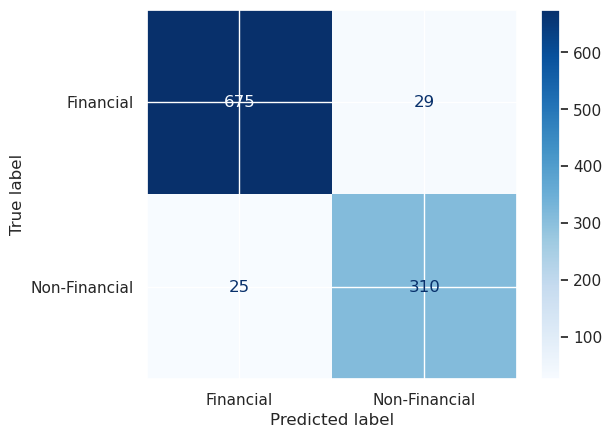

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Set the model to evaluation mode
model.eval()

# Use trainer.predict() to get predicted logits and labels
trainer_pred = trainer.predict(dataset_test)
predictions = trainer_pred.predictions
labels = trainer_pred.label_ids
metrics = trainer_pred.metrics

print(metrics)

# Get the predicted class indices
predicted_indices = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, predicted_indices)

# Replace with your class labels
class_labels = ["Financial", "Non-Financial"] 

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.show()


In [16]:
def infer(sentence):
    inputs = tokenizer(sentence, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    inputs = {key: tensor.to('cuda') for key, tensor in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_label = torch.argmax(logits, dim=-1).item()

    print("# Inference")
    print(" - Sentence: {}".format(sentence))
    label = "Financial"
    if predicted_label == 1:
        label = "Non-Financial"
    print("- Predicted Label :", label)
    print("")

In [17]:
# Non-fiancial
sent_1 = "Each investor should carefully consider the risks associated with the investment and make a determination based upon the investors own particular circumstances, that the investment is consistent with the investors investment objectives."
infer(sent_1)

# Financial
sent_2 = "While its economy shrank by 3.0% last yeara smaller- than-expected decline given the benefit from selling energy at high priceswe expect it to contract by an additional 2.6% in 2023."
infer(sent_2)

# Inference
 - Sentence: Each investor should carefully consider the risks associated with the investment and make a determination based upon the investors own particular circumstances, that the investment is consistent with the investors investment objectives.
- Predicted Label : Non-Financial

# Inference
 - Sentence: While its economy shrank by 3.0% last yeara smaller- than-expected decline given the benefit from selling energy at high priceswe expect it to contract by an additional 2.6% in 2023.
- Predicted Label : Financial



In [18]:
model_path = 'finlegal-classifier'

# Save the model and tokenizer
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('finlegal-classifier/tokenizer_config.json',
 'finlegal-classifier/special_tokens_map.json',
 'finlegal-classifier/vocab.txt',
 'finlegal-classifier/added_tokens.json')